## Neural Network

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Load the dataset
df = pd.read_csv('final_no_na_df.csv')
# Drop any unnecessary columns
df = df.drop(columns=['Unnamed: 0'])

In [81]:
df.head()

,Maker,Genmodel,Genmodel_ID,avg_sales,avg_price,avg_gas_emission,avg_engine_size,majority_fuel_type,avg_engine_power,avg_wheelbase,...,majority_bodytype,majority_gearbox,avg_prob_angry,avg_prob_disgust,avg_prob_fear,avg_prob_happy,avg_prob_sad,avg_prob_surprise,avg_prob_neutral,majority_label
0,ABARTH,ABARTH 124,2_1,23.000000,30524.090909,150.272727,1368.00000,Petrol,170.000000,2310.0,...,Convertible,Automatic,0.175967,0.034096,0.136359,0.216322,0.138663,0.255023,0.043571,Surprise
1,ABARTH,ABARTH 595,2_4,2259.857143,19294.044586,141.968153,1368.00000,Petrol,155.323276,2300.0,...,Hatchback,Manual,0.134758,0.021127,0.053783,0.246813,0.393607,0.103379,0.046533,Sad
2,ABARTH,ABARTH SPIDER,2_1,469.666667,30524.090909,150.272727,1368.00000,Petrol,170.000000,2310.0,...,Convertible,Automatic,0.175967,0.034096,0.136359,0.216322,0.138663,0.255023,0.043571,Surprise
3,ALFA ROMEO,ALFA ROMEO 159,4_4,635.777778,24677.129801,196.880795,2259.50596,Petrol,170.283019,2700.0,...,Saloon,Manual,0.133810,0.063153,0.098016,0.229438,0.254638,0.137605,0.083341,Sad
4,ALFA ROMEO,ALFA ROMEO 4C,4_7,61.000000,56126.111111,158.777778,1742.00000,Petrol,240.000000,2380.0,...,Convertible,Automatic,0.103934,0.035740,0.213550,0.239398,0.091109,0.209123,0.107145,Happy


In [82]:
# Separate features and target
X = df.drop(columns=['avg_sales', 'Maker', 'Genmodel','Genmodel_ID'])
y = df['avg_sales']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Convert categorical columns to integer codes
for col in categorical_cols:
    X[col] = X[col].astype('category').cat.codes

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize OrdinalEncoder with handle_unknown parameter
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train[categorical_cols])

# Transform categorical columns
X_train_cats = encoder.transform(X_train[categorical_cols])
X_test_cats = encoder.transform(X_test[categorical_cols])

# Adjust indices to be non-negative
X_train_cats = X_train_cats + 1  # Unknown categories will be 0
X_test_cats = X_test_cats + 1

# Scale numerical columns
scaler = StandardScaler()
X_train_nums = scaler.fit_transform(X_train[numerical_cols])
X_test_nums = scaler.transform(X_test[numerical_cols])

# Convert to PyTorch tensors
X_train_cat = torch.tensor(X_train_cats, dtype=torch.long)
X_test_cat = torch.tensor(X_test_cats, dtype=torch.long)
X_train_num = torch.tensor(X_train_nums, dtype=torch.float32)
X_test_num = torch.tensor(X_test_nums, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [83]:
X.head()
# Get the number of numerical features
num_numerical_features = X_train_num.shape[1]

In [77]:
# Calculate embedding sizes
embedding_sizes = []
for categories in encoder.categories_:
    num_categories = len(categories) + 1  # +1 for unknown category
    embedding_dim = min(50, (num_categories + 1) // 2)
    embedding_sizes.append((num_categories, embedding_dim))

# Define a list of hyperparameters to search over
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'embedding_dim': [16, 32],
    'units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100],
    'num_layers': [2, 3]
}

# Randomly sample hyperparameter combinations
num_trials = 10
hyperparameter_combinations = [
    {key: random.choice(values) for key, values in param_grid.items()}
    for _ in range(num_trials)
]

# Define the model class with embeddings
class SalesPredictorWithEmbedding(nn.Module):
    def __init__(self, embedding_sizes, num_numerical_features, units, dropout_rate, num_layers):
        super(SalesPredictorWithEmbedding, self).__init__()
        # Embedding layers
        self.embeddings = nn.ModuleList([nn.Embedding(num_categories, embedding_dim) for num_categories, embedding_dim in embedding_sizes])
        
        # Fully connected layers
        embedding_dim_total = sum([embedding_dim for _, embedding_dim in embedding_sizes])
        layer_dims = [embedding_dim_total + num_numerical_features] + [units] * num_layers
        layers = []
        
        for i in range(len(layer_dims) - 1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(layer_dims[-1], 1))  # Final layer for output
        self.model = nn.Sequential(*layers)
        
    def forward(self, x_cat, x_num):
        embeddings = [self.embeddings[i](x_cat[:, i]) for i in range(x_cat.shape[1])]
        x = torch.cat(embeddings + [x_num], dim=1)
        return self.model(x)

# Track the best model
best_mae = float('inf')
best_params = None

# Hyperparameter tuning loop
for params in hyperparameter_combinations:
    print(f"Trying hyperparameters: {params}")
    
    # Update embedding sizes with current embedding dimension
    current_embedding_sizes = [
        (num_categories, params['embedding_dim']) for num_categories, _ in embedding_sizes
    ]
    
    # Initialize model with current hyperparameters
    model = SalesPredictorWithEmbedding(
        current_embedding_sizes,
        num_numerical_features,
        units=params['units'],
        dropout_rate=params['dropout_rate'],
        num_layers=params['num_layers']
    )
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    
    # Training loop
    for epoch in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_cat, X_train_num)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    
    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_cat, X_test_num)
        mae = mean_absolute_error(y_test.numpy(), predictions.numpy())
        print(f"MAE for current model: {mae}")
    
    # Track the best model
    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best MAE: {best_mae}")
print(f"Best Hyperparameters: {best_params}")

Trying hyperparameters: {'lr': 0.1, 'embedding_dim': 16, 'units': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'epochs': 100, 'num_layers': 3}
MAE for current model: 4155.197265625
Trying hyperparameters: {'lr': 0.1, 'embedding_dim': 32, 'units': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'epochs': 100, 'num_layers': 3}
MAE for current model: 4064.392822265625
Trying hyperparameters: {'lr': 0.1, 'embedding_dim': 16, 'units': 128, 'dropout_rate': 0.2, 'batch_size': 32, 'epochs': 100, 'num_layers': 3}
MAE for current model: 3482.32373046875
Trying hyperparameters: {'lr': 0.001, 'embedding_dim': 32, 'units': 128, 'dropout_rate': 0.2, 'batch_size': 32, 'epochs': 50, 'num_layers': 3}
MAE for current model: 3664.672119140625
Trying hyperparameters: {'lr': 0.001, 'embedding_dim': 16, 'units': 32, 'dropout_rate': 0.4, 'batch_size': 16, 'epochs': 100, 'num_layers': 2}
MAE for current model: 4215.8349609375
Trying hyperparameters: {'lr': 0.001, 'embedding_dim': 32, 'units': 128, 'dropout_rate': 0.

Epoch 1/200, Loss: 89722400.1538
Epoch 10/200, Loss: 59518991.2308
Epoch 20/200, Loss: 58973953.3846
Epoch 30/200, Loss: 51127262.9231
Epoch 40/200, Loss: 47867979.7115
Epoch 50/200, Loss: 45769666.0769
Epoch 60/200, Loss: 36469285.7308
Epoch 70/200, Loss: 31929923.5385
Epoch 80/200, Loss: 32398247.7692
Epoch 90/200, Loss: 29919565.6923
Epoch 100/200, Loss: 22817013.0000
Epoch 110/200, Loss: 20362129.9231
Epoch 120/200, Loss: 25938808.0385
Epoch 130/200, Loss: 25172502.1538
Epoch 140/200, Loss: 18977280.9904
Epoch 150/200, Loss: 20379560.4615
Epoch 160/200, Loss: 18216376.6923
Epoch 170/200, Loss: 14885569.3654
Epoch 180/200, Loss: 15022696.8846
Epoch 190/200, Loss: 13984014.1923
Epoch 200/200, Loss: 25345325.7981
Training MAE: 2274.6826, Training MSE: 28217680.0000
Test MAE: 3073.3384, Test MSE: 44850428.0000


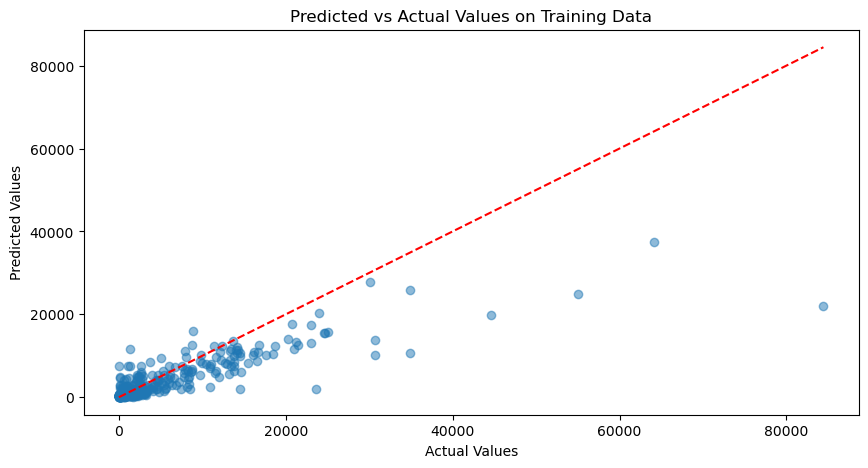

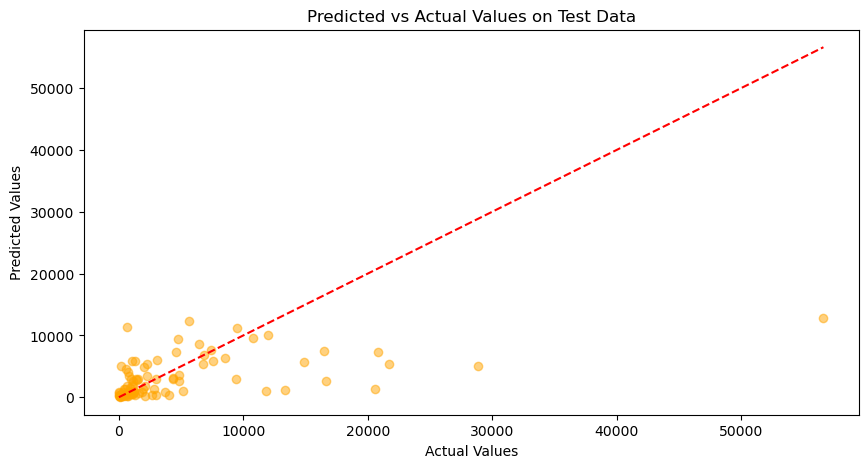

In [88]:
# Use the best hyperparameters found earlier
best_params = {
    'lr': 0.01,  # Replace with the best learning rate found
    'embedding_dim': 32,  # Replace with the best embedding dimension found
    'units': 128,  # Replace with the best number of units found
    'dropout_rate': 0.3,  # Replace with the best dropout rate found
    'batch_size': 32,  # Replace with the best batch size found
    'epochs': 200,  # Replace with the best number of epochs found
    'num_layers': 3  # Replace with the best number of layers found
}

# Update embedding sizes with the best embedding dimension
current_embedding_sizes = [
    (num_categories, best_params['embedding_dim']) for num_categories, _ in embedding_sizes
]

# Initialize model with the best hyperparameters
model = SalesPredictorWithEmbedding(
    current_embedding_sizes,
    num_numerical_features,
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    num_layers=best_params['num_layers']
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

# Create DataLoader for mini-batch training
from torch.utils.data import TensorDataset, DataLoader

# Combine categorical and numerical features for training
train_dataset = TensorDataset(X_train_cat, X_train_num, y_train)
test_dataset = TensorDataset(X_test_cat, X_test_num, y_test)

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Training loop with mini-batch
for epoch in range(best_params['epochs']):
    model.train()
    epoch_loss = 0
    for X_cat_batch, X_num_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_num_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{best_params['epochs']}, Loss: {avg_loss:.4f}")

# Evaluate the model on training and test sets
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_cat, X_train_num)
    y_test_pred = model(X_test_cat, X_test_num)
    
    # Convert tensors to numpy arrays
    y_train_pred_np = y_train_pred.numpy()
    y_test_pred_np = y_test_pred.numpy()
    y_train_np = y_train.numpy()
    y_test_np = y_test.numpy()
    
    # Calculate evaluation metrics
    train_mae = mean_absolute_error(y_train_np, y_train_pred_np)
    train_mse = mean_squared_error(y_train_np, y_train_pred_np)
    test_mae = mean_absolute_error(y_test_np, y_test_pred_np)
    test_mse = mean_squared_error(y_test_np, y_test_pred_np)
    
    print(f"Training MAE: {train_mae:.4f}, Training MSE: {train_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}")

# Visualize predicted vs actual values for training data
plt.figure(figsize=(10,5))
plt.scatter(y_train_np, y_train_pred_np, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values on Training Data')
plt.plot([y_train_np.min(), y_train_np.max()], [y_train_np.min(), y_train_np.max()], 'r--')
plt.show()

# Visualize predicted vs actual values for test data
plt.figure(figsize=(10,5))
plt.scatter(y_test_np, y_test_pred_np, alpha=0.5, color='orange')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values on Test Data')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.show()

## Linear Model

In [95]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [102]:
# Load the dataset
df = pd.read_csv('final_no_na_df.csv')

# Define target variable and drop high-cardinality categorical variables
X = df.drop(columns=['Unnamed: 0', 'avg_sales', 'Maker', 'Genmodel', 'Genmodel_ID'])
y = df['avg_sales']

# One-hot encode the categorical variables
X = pd.get_dummies(X, drop_first=True)

# Add a constant to the model (intercept)
X = sm.add_constant(X)

bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)
        
# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Output the model summary
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_sales   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     3.338
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           1.73e-09
Time:                        13:52:18   Log-Likelihood:                -5042.0
No. Observations:                 487   AIC:                         1.016e+04
Df Residuals:                     450   BIC:                         1.031e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        2.431e+10   2.44e+10      0.998      0.319   -2.36e+10    7.22e+10
avg_price                       0.0281      0.029      0.975      0.330      -0.029       0.085
avg_gas_emission              -15.5030     18.395     -0.843      0.400     -51.653      20.647
avg_engine_size                 1.0040      1.585      0.633      0.527      -2.111       4.119
avg_engine_power              -43.9262     19.385     -2.266      0.024     -82.022      -5.830
avg_wheelbase                  -0.3005      1.001     -0.300      0.764      -2.269       1.668
avg_height                     -6.1452      6.159     -0.998      0.319     -18.249       5.959
avg_width                       6.2207      3.737      1.665      0.097      -1.123      13.564
avg_length                     -1.5378      2.136     -0.720      0.472      -5.735       2.659
avg_mpg                       152.2634     69.673      2.185      0.029      15.339     289.188
avg_top_speed                 137.1542     70.888      1.935      0.054      -2.158     276.467
majority_seat_num            1209.1602    711.491      1.699      0.090    -189.096    2607.417
majority_door_num           -1265.6230    754.160     -1.678      0.094   -2747.736     216.490
majority_engine_size         1442.4942   1120.692      1.287      0.199    -759.946    3644.934
avg_prob_angry              -2.431e+10   2.44e+10     -0.998      0.319   -7.22e+10    2.36e+10
avg_prob_disgust            -2.431e+10   2.44e+10     -0.998      0.319   -7.22e+10    2.36e+10
avg_prob_fear               -2.431e+10   2.44e+10     -0.998      0.319   -7.22e+10    2.36e+10
avg_prob_happy              -2.431e+10   2.44e+10     -0.998      0.319   -7.22e+10    2.36e+10
avg_prob_sad                -2.431e+10   2.44e+10     -0.998      0.319   -7.22e+10    2.36e+10
avg_prob_surprise           -2.431e+10   2.44e+10     -0.998      0.319   -7.22e+10    2.36e+10
avg_prob_neutral            -2.431e+10   2.44e+10     -0.998      0.319   -7.22e+10    2.36e+10
majority_fuel_type_Other    -6975.0658   3362.911     -2.074      0.039   -1.36e+04    -366.107
majority_fuel_type_Petrol    1729.0978   1059.310      1.632      0.103    -352.711    3810.907
majority_bodytype_Coupe      -132.2187   1926.978     -0.069      0.945   -3919.212    3654.774
majority_bodytype_Estate     3102.6024   3272.720      0.948      0.344   -3329.109    9534.314
majority_bodytype_Hatchback  6116.1906   2794.148      2.189      0.029     624.993    1.16e+04
majority_bodytype_Limousine  -956.7850   9864.735     -0.097      0.923   -2.03e+04    1.84e+04
majority_bodytype_MPV        2174.7796   3424.624      0.635      0.526   -4555.462    8905.021
majority_bodytype_Pickup     6328.7694   8823.370      0.717      0.474    -1.1e+04    2.37e+04
majority_bo